# Assignment 2: Hybrid Images and Scale-space blob detection

In [4]:
# Libraries you will find useful
import numpy as np
import scipy 
import skimage.io
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Part 1: Hybrid Images

In [5]:
# Crop and align the images such that the objects and their edges are aligned. 
# You are free to use any image editing tool for this and there is no need for code for this step.

# Load cropped and aligned images
c1 = skimage.io.imread('p1_1/c1_aligned.jpg')
c2 = skimage.io.imread('p1_1/c2_aligned.jpg')

In [6]:
# Read aligned input images and convert them to grayscale 
from skimage.color import rgb2gray

c1 = rgb2gray(c1)
c2 = rgb2gray(c2)

In [7]:
# Apply a low-pass filter, i.e., a standard 2D Gaussian filter, on the first (smooth) image. 
from scipy.ndimage import gaussian_filter

c1f = c1 - gaussian_filter(c1, sigma=3)

In [8]:
# Apply a high-pass filter on the second image. 
# The paper suggests using an impulse (identity) filter minus a Gaussian filter for this operation.
c2f = gaussian_filter(c2, sigma=7)

In [9]:
# Use your intuition and trial and error to determine good values of σ for the high-pass and low-pass filters
# One of the σ's should always be higher than the other (which one?), but the optimal values can vary from image to image.

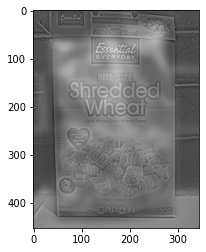

In [10]:
# Add or average the tranformed images to create the hybrid image.
c = (c1f + c2f) / 2.
plt.imshow(c)
plt.set_cmap('gray')

## Part 2: Scale-space blob detection

In [11]:
# load image and convert it to gray scale
im = skimage.io.imread('assignment2_images/butterfly.jpg')
im = rgb2gray(im) # rgb2gray normalize to [0, 1]

In [12]:
# Creating the Laplacian filter
# Pay careful attention to setting the right filter mask size. Hint: Should the filter width be odd or even?

In [13]:
# filtering the image (two implmementations)
# one that increases filter size, and one that downsamples the image
# For timing, use time.time()
from scipy.ndimage.filters import gaussian_laplace
from skimage.transform import resize

def laplacian_pyramid_1(im, max_layer, downscale, sigma):
    """Filter by different gaussian."""
    for _ in range(max_layer):  
        im_l = gaussian_laplace(im, sigma, truncate=6)
        yield im_l * sigma**2, sigma
        sigma *= downscale

def laplacian_pyramid_2(im, max_layer, downscale, sigma):
    """Filter by downsampling."""
    im0 = im.copy()
    shape0, sigma0 = im.shape, sigma
    for _ in range(max_layer):
        out_shape = np.ceil(np.array(im.shape) / downscale)
        
        im_l = gaussian_laplace(im, sigma0, truncate=6)
        im_l = resize(im_l, shape0)
        yield im_l * sigma0**2, sigma

        im = resize(im0, out_shape)
        sigma *= downscale

def laplacian_pyramid(
    im, max_layer=-1, downscale=2, sigma=None, method='resize', return_sigma=True
):
    if max_layer == -1:
        max_layer = int(np.ceil(np.log(np.max(im.shape)) / np.log(downscale)))
    
    downscale = float(downscale)
    
    if sigma is None:
        # covers >99% of distribution
        sigma = 2 * downscale / 6.  
    else:
        sigma = float(sigma)

    try:
        func = {
            'sigma': laplacian_pyramid_1,
            'resize': laplacian_pyramid_2
        }[method]
    except KeyError:
        raise ValueError(f"unknown method '{method}'")
    for level in func(im, max_layer, downscale, sigma):
        yield level if return_sigma else level[0]

layer 0, sigma=2.0000
.. diff_max=0.0000
=====
layer 1, sigma=4.0000
.. diff_max=0.0032
=====
layer 2, sigma=8.0000
.. diff_max=0.0047
=====
layer 3, sigma=16.0000
.. diff_max=0.0030
=====
layer 4, sigma=32.0000
.. diff_max=0.0021
=====


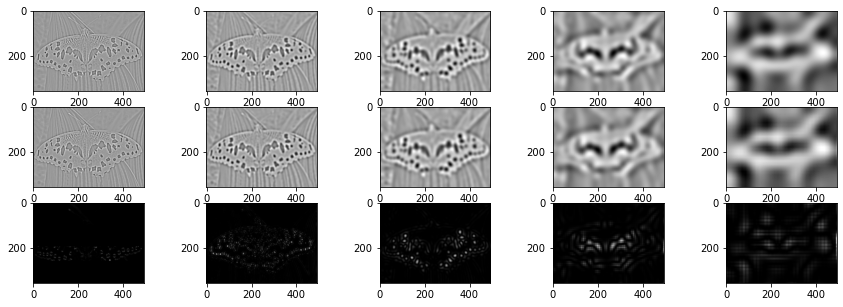

In [14]:
# sanity check, compare different pyramid implementation
from numpy.testing import assert_array_almost_equal_nulp, assert_allclose

max_layer = 5
downscale = 2
pyramids = tuple(
    laplacian_pyramid(
        im, 
        max_layer=max_layer, 
        downscale=downscale, 
        sigma=2,
        method=method, 
        return_sigma=True
    )
    for method in ('sigma', 'resize')
)
fix, ax = plt.subplots(3, max_layer, figsize=(15, 5))
for i, layers in enumerate(zip(*pyramids)):
    (im_sig, s_sig), (im_res, s_res) = layers
    
    assert_array_almost_equal_nulp(s_sig, s_res)
    print(f'layer {i}, sigma={s_sig:.4f}')

    ax[0, i].imshow(im_sig, cmap='gray')
    ax[1, i].imshow(im_res, cmap='gray')
    im_diff = np.abs(im_sig-im_res)**2
    print(f'.. diff_max={np.max(im_diff):.4f}')
    ax[2, i].imshow(im_diff, cmap='gray')
    try:
        assert_allclose(im_sig, im_res, atol=0.5, verbose=False)
    except AssertionError as err:
        print(f'.. failed\n{err}')

    print('=====')
    
plt.show()

In [15]:
min_sigma = 2
max_sigma = 50
n_sigma = 10

scale = np.logspace(np.log10(min_sigma), np.log10(max_sigma), n_sigma)

In [24]:
from skimage.feature import peak_local_max
from scipy.ndimage import rank_filter

def blob_detection(
    im, min_sigma=1, max_sigma=50, n_sigma=10, method='resize', threshold=0.2
):
    sigmas = np.logspace(np.log10(min_sigma), np.log10(max_sigma), n_sigma)
    pyramid0, sigmas = zip(*list(
        laplacian_pyramid(
            im, 
            max_layer=n_sigma, 
            downscale=sigmas[1]/sigmas[0], 
            sigma=sigmas[0], 
            method=method, 
            return_sigma=True
        )
    ))
    pyramid0 = np.stack(pyramid0, axis=-1)
    sigmas = np.array(sigmas)

    # flip sign, we are actually working with min
    pyramid0 = -pyramid0

    # non-maximal supression along each scale
    pyramid = rank_filter(
        pyramid0, 
        -1, 
        footprint=np.ones((3,) * (pyramid0.ndim-1) + (1,))
    )    
    # the threshold
    scale_max = np.max(pyramid, axis=-1)

    # DEBUG
    fig, ax = plt.subplots()
    ax.imshow(scale_max)
    # DEBUG
    fig, ax = plt.subplots(1, n_sigma, figsize=(15, 5))
    for i in range(n_sigma):
        ax[i].imshow(pyramid[..., i], cmap='gray')

    for i in range(n_sigma):
        pyramid[..., i] = (pyramid0[..., i] == scale_max) * im

    maxima = np.where(pyramid > threshold)
    maxima = np.stack(maxima).T

    """
    # NOTE using NMS by scikit-image
    maxima = peak_local_max(
        pyramid, 
        threshold_abs=threshold,
        footprint=np.ones((3,) * (pyramid.ndim-1) + (n_sigma,)), 
        threshold_rel=0.0,
    )
    """

    # replace index with actual sigma
    sigmas = sigmas[maxima[:, -1]]
    maxima = np.hstack([maxima[:, :-1], sigmas[:, np.newaxis]])
    return maxima

In [17]:
# nonmaximum suppression in scale space
# you may find functions scipy.ndimage.filters.rank_filter or scipy.ndimage.filters.generic_filter useful

In [18]:
# To display the detected regions as circle
from matplotlib.patches import Circle
def show_all_circles(image, cx, cy, rad, color='r', figsize=(8, 6)):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

(288, 3)


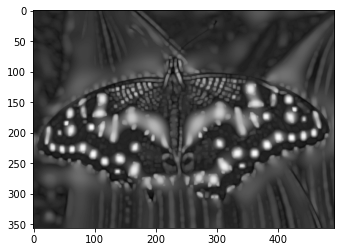

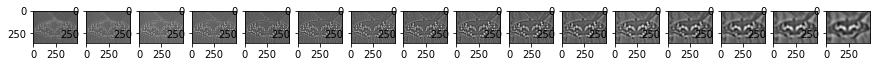

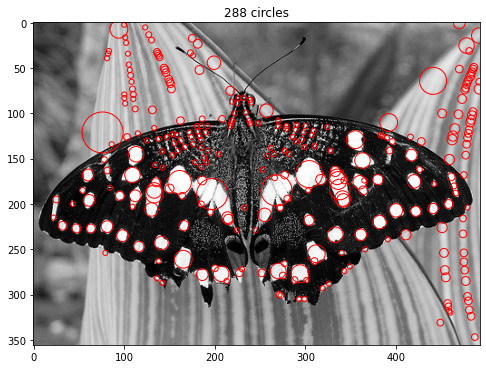

In [25]:
from skimage.feature.blob import _prune_blobs

im = skimage.io.imread('assignment2_images/einstein.jpg')
im = rgb2gray(im) # rgb2gray normalize to [0, 1]

maxima = blob_detection(
    im, min_sigma=2, max_sigma=16, n_sigma=16, method='sigma', threshold=0.8
)
print(maxima.shape)

# turn sigma to radius
maxima[:, -1] *= np.sqrt(2)
# unzip columns
cy, cx, r = maxima.T

show_all_circles(im, cx, cy, r)